# Q4: Study Neural Collapse in the presence of OOD data

This notebook studies how Neural Collapse metrics evolve when Out-of-Distribution (OOD) data
is treated as an extra class alongside the ID classes.

We focus on:
- **NC5** — ID/OOD Orthogonality (eq. 5 of the NECO paper)
- **NC1** (ID only vs ID+OOD) — Does OOD break within/between-class collapse?
- **NC2** (ID only vs ID+OOD) — Does OOD break equiangularity?
- **PCA projections** — Visualise the ETF structure and OOD orthogonality in 2D and 3D

## Setup

In [1]:
# Mount Google Drive (for saving checkpoints)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Clone repository
import os
if not os.path.exists('/content/OOD-Detection-Project---CSC_5IA23'):
    !git clone https://github.com/DiegoFleury/OOD-Detection-Project---CSC_5IA23/
%cd /content/OOD-Detection-Project---CSC_5IA23

Cloning into 'OOD-Detection-Project---CSC_5IA23'...
remote: Enumerating objects: 356, done.
remote: Counting objects: 100% (356/356), done.
remote: Compressing objects: 100% (236/236), done.
remote: Total 356 (delta 189), reused 266 (delta 110), pack-reused 0 (from 0)
Receiving objects: 100% (356/356), 8.73 MiB | 11.49 MiB/s, done.
Resolving deltas: 100% (189/189), done.
/content/OOD-Detection-Project---CSC_5IA23


In [3]:
# Install dependencies
!pip install -q torch torchvision matplotlib seaborn scikit-learn pyyaml imageio tqdm plotly

In [4]:
# Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import yaml
import glob
import re
import os

from src.models import ResNet18
from src.data import get_cifar100_loaders

# Check GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


In [5]:
# Load config
with open('configs/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("Configuration:")
print(yaml.dump(config, default_flow_style=False))

Configuration:
data:
  augment: true
  data_dir: ./data
  num_workers: 2
device: cuda
model:
  num_classes: 100
ood:
  datasets:
  - SVHN
  - CIFAR10
  - Textures
  sampling_ratio: 0.1
  tpt_mask:
  - 0
  - 0
  - 0
  - 0
  - 0
  - 0
  - 0
  - 0
  - 1
  - 1
  - 1
  - 1
paths:
  checkpoints: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints
  figures: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures
  gifs: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/gifs
  metrics: /content/drive/MyDrive/Colab Notebooks/OOD/Results/metrics
  ood_detection: /content/drive/MyDrive/Colab Notebooks/OOD/Results/ood_scoring
  results: /content/drive/MyDrive/Colab Notebooks/OOD/Results
  tables: /content/drive/MyDrive/Colab Notebooks/OOD/Results/tables
training:
  batch_size: 128
  checkpoint_frequency: 25
  early_stopping_patience: 999
  epochs: 300
  lr: 0.1
  momentum: 0.9
  val_split: 0.1
  weight_decay: 0.0005



## 1. Load Data

- **CIFAR-100** — In-Distribution (ID)
- **SVHN** and **CIFAR-10** — Out-of-Distribution (OOD)

In [6]:
# ID data: CIFAR-100
print("Loading CIFAR-100 (ID) dataset...")

train_loader, val_loader, test_loader = get_cifar100_loaders(
    data_dir=config['data']['data_dir'],
    batch_size=config['training']['batch_size'],
    num_workers=config['data']['num_workers'],
    augment=False,
    val_split=config['training']['val_split']
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches:   {len(val_loader)}")
print(f"Test batches:  {len(test_loader)}")

Loading CIFAR-100 (ID) dataset...


100%|██████████| 169M/169M [00:13<00:00, 12.9MB/s]


Train batches: 352
Val batches:   40
Test batches:  79


In [7]:
# OOD data: SVHN + CIFAR-10
import torchvision
import torchvision.transforms as transforms

ood_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5071, 0.4867, 0.4408],
        std=[0.2675, 0.2565, 0.2761]
    ),
])

# SVHN
print("Loading SVHN (OOD)...")
svhn_dataset = torchvision.datasets.SVHN(
    root=config['data']['data_dir'], split='test',
    transform=ood_transform, download=True,
)
svhn_loader = torch.utils.data.DataLoader(
    svhn_dataset, batch_size=config['training']['batch_size'],
    shuffle=False, num_workers=config['data']['num_workers'],
)
print(f"SVHN test samples: {len(svhn_dataset)}")

# CIFAR-10
print("Loading CIFAR-10 (OOD)...")
cifar10_dataset = torchvision.datasets.CIFAR10(
    root=config['data']['data_dir'], train=False,
    transform=ood_transform, download=True,
)
cifar10_loader = torch.utils.data.DataLoader(
    cifar10_dataset, batch_size=config['training']['batch_size'],
    shuffle=False, num_workers=config['data']['num_workers'],
)
print(f"CIFAR-10 test samples: {len(cifar10_dataset)}")

Loading SVHN (OOD)...


100%|██████████| 64.3M/64.3M [00:13<00:00, 4.94MB/s]


SVHN test samples: 26032
Loading CIFAR-10 (OOD)...


100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


CIFAR-10 test samples: 10000


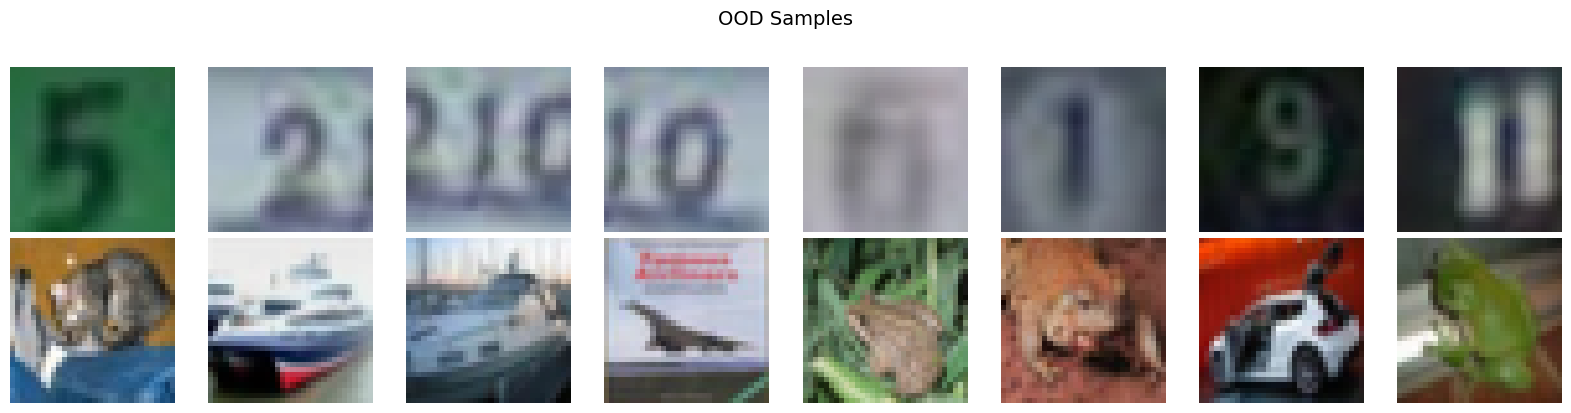

In [8]:
# Visualize OOD samples
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
fig.suptitle("OOD Samples", fontsize=14, y=1.02)

svhn_images, _ = next(iter(svhn_loader))
c10_images, _ = next(iter(cifar10_loader))

for i in range(8):
    for row, (imgs, name) in enumerate([(svhn_images, 'SVHN'), (c10_images, 'CIFAR-10')]):
        img = imgs[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.2675, 0.2565, 0.2761]) + np.array([0.5071, 0.4867, 0.4408])
        img = np.clip(img, 0, 1)
        axes[row, i].imshow(img)
        axes[row, i].axis('off')
        if i == 0:
            axes[row, i].set_ylabel(name, fontsize=12, rotation=0, labelpad=50)

plt.tight_layout()

ood_fig_dir = os.path.join(config['paths']['figures'], 'ood')
os.makedirs(ood_fig_dir, exist_ok=True)
plt.savefig(os.path.join(ood_fig_dir, 'ood_samples.png'), dpi=150, bbox_inches='tight')
plt.show()

## 2. Import NC OOD Module

In [9]:
from src.neural_collapse.nc_ood import (
    load_checkpoints_and_analyze_ood,
    plot_nc5_convergence,
    plot_ood_summary,
    save_ood_metrics_yaml,
    NCOODTracker,
    plot_pca_2d,
    plot_pca_3d_interactive,
)

print("NC OOD module imported!")

NC OOD module imported!


## 3. NC5 Analysis Across Training Epochs

NC5 (eq. 5 of the paper) measures whether ID class means become orthogonal to the OOD global mean during training:

$$\text{OrthoDev} = \text{Avg}_c \left| \frac{\langle \mu_c, \mu_G^{\text{OOD}} \rangle}{\|\mu_c\| \cdot \|\mu_G^{\text{OOD}}\|} \right|$$

This should decrease toward 0 as the model enters the Terminal Phase of Training.

In [10]:
# Configure paths
checkpoint_dir = config['paths']['checkpoints']
figures_dir = os.path.join(config['paths']['figures'], 'ood')
metrics_dir = config['paths']['metrics']
os.makedirs(figures_dir, exist_ok=True)
os.makedirs(metrics_dir, exist_ok=True)

# Verify checkpoints
def get_epoch_num(path):
    match = re.search(r'epoch(\d+)', path)
    return int(match.group(1)) if match else 0

checkpoints = glob.glob(os.path.join(checkpoint_dir, 'resnet18_cifar100_*.pth'))
print(f"Checkpoints found: {len(checkpoints)}")
for ckpt in sorted(checkpoints, key=get_epoch_num)[:5]:
    print(f"   - {os.path.basename(ckpt)}")
if len(checkpoints) > 5:
    print(f" and {len(checkpoints) - 5} more")

Checkpoints found: 13
   - resnet18_cifar100_best.pth
   - resnet18_cifar100_epoch25.pth
   - resnet18_cifar100_epoch50.pth
   - resnet18_cifar100_epoch75.pth
   - resnet18_cifar100_epoch100.pth
 and 8 more


In [11]:
# NC5 analysis with SVHN as OOD
print("Analyzing NC metrics with OOD=SVHN...")
print(f"   Device: {device}")
print(f"   ID classes: {config['model']['num_classes']}")
print()

tracker_svhn = load_checkpoints_and_analyze_ood(
    checkpoint_dir=checkpoint_dir,
    model_class=ResNet18,
    id_loader=train_loader,
    ood_loader=svhn_loader,
    device=device,
    num_classes=config['model']['num_classes'],
    checkpoint_pattern='resnet18_cifar100_*.pth',
    epoch_regex=r'epoch(\d+)',
    verbose=True,
)

print("\n" + tracker_svhn.summary())

Analyzing NC metrics with OOD=SVHN...
   Device: cuda
   ID classes: 100



NC+OOD Analysis:   8%|▊         | 1/13 [00:59<11:53, 59.42s/it]

  Epoch    0 | NC5 0.346988 | NC1(ID) 0.1303 | NC1(+OOD) 0.3524 | NC2eq(ID) 0.0570 | NC2eq(+OOD) 0.0575


NC+OOD Analysis:  15%|█▌        | 2/13 [02:01<11:13, 61.20s/it]

  Epoch   25 | NC5 0.458705 | NC1(ID) 4.9756 | NC1(+OOD) 4.6220 | NC2eq(ID) 0.1711 | NC2eq(+OOD) 0.1711


NC+OOD Analysis:  23%|██▎       | 3/13 [03:05<10:22, 62.25s/it]

  Epoch   50 | NC5 0.517990 | NC1(ID) 3.3757 | NC1(+OOD) 3.0596 | NC2eq(ID) 0.1622 | NC2eq(+OOD) 0.1619


NC+OOD Analysis:  31%|███       | 4/13 [04:09<09:26, 62.92s/it]

  Epoch   75 | NC5 0.503133 | NC1(ID) 3.0605 | NC1(+OOD) 2.7614 | NC2eq(ID) 0.1501 | NC2eq(+OOD) 0.1500


NC+OOD Analysis:  38%|███▊      | 5/13 [05:13<08:28, 63.53s/it]

  Epoch  100 | NC5 0.491883 | NC1(ID) 2.4806 | NC1(+OOD) 2.6058 | NC2eq(ID) 0.1392 | NC2eq(+OOD) 0.1391


NC+OOD Analysis:  46%|████▌     | 6/13 [06:16<07:22, 63.25s/it]

  Epoch  125 | NC5 0.505458 | NC1(ID) 2.1624 | NC1(+OOD) 1.9371 | NC2eq(ID) 0.1373 | NC2eq(+OOD) 0.1373


NC+OOD Analysis:  54%|█████▍    | 7/13 [07:20<06:19, 63.31s/it]

  Epoch  150 | NC5 0.495052 | NC1(ID) 1.9183 | NC1(+OOD) 1.8338 | NC2eq(ID) 0.1221 | NC2eq(+OOD) 0.1220


NC+OOD Analysis:  62%|██████▏   | 8/13 [08:23<05:17, 63.48s/it]

  Epoch  175 | NC5 0.503723 | NC1(ID) 1.6058 | NC1(+OOD) 1.4406 | NC2eq(ID) 0.1190 | NC2eq(+OOD) 0.1194


NC+OOD Analysis:  69%|██████▉   | 9/13 [09:23<04:08, 62.19s/it]

  Epoch  200 | NC5 0.510483 | NC1(ID) 1.1183 | NC1(+OOD) 1.1207 | NC2eq(ID) 0.0980 | NC2eq(+OOD) 0.0985


NC+OOD Analysis:  77%|███████▋  | 10/13 [10:28<03:09, 63.11s/it]

  Epoch  225 | NC5 0.479221 | NC1(ID) 0.6443 | NC1(+OOD) 0.7642 | NC2eq(ID) 0.0786 | NC2eq(+OOD) 0.0790


NC+OOD Analysis:  85%|████████▍ | 11/13 [11:32<02:06, 63.33s/it]

  Epoch  250 | NC5 0.379792 | NC1(ID) 0.2081 | NC1(+OOD) 0.3774 | NC2eq(ID) 0.0602 | NC2eq(+OOD) 0.0607


NC+OOD Analysis:  92%|█████████▏| 12/13 [12:35<01:03, 63.42s/it]

  Epoch  275 | NC5 0.342332 | NC1(ID) 0.1353 | NC1(+OOD) 0.3497 | NC2eq(ID) 0.0572 | NC2eq(+OOD) 0.0577


NC+OOD Analysis: 100%|██████████| 13/13 [13:39<00:00, 63.05s/it]

  Epoch  300 | NC5 0.353054 | NC1(ID) 0.1255 | NC1(+OOD) 0.3501 | NC2eq(ID) 0.0567 | NC2eq(+OOD) 0.0573

NC OOD METRICS SUMMARY
Epochs analyzed: 13
Epoch range: 0 → 300
Final NC5 OrthoDev: 0.353054
Final NC1 (ID only): 0.1255
Final NC1 (ID+OOD):  0.3501
Final NC2 equiang (ID):    0.0567
Final NC2 equiang (ID+OOD):0.0573


In [12]:
# NC5 analysis with CIFAR-10 as OOD
print("Analyzing NC metrics with OOD=CIFAR-10...")
print()

tracker_cifar10 = load_checkpoints_and_analyze_ood(
    checkpoint_dir=checkpoint_dir,
    model_class=ResNet18,
    id_loader=train_loader,
    ood_loader=cifar10_loader,
    device=device,
    num_classes=config['model']['num_classes'],
    checkpoint_pattern='resnet18_cifar100_*.pth',
    epoch_regex=r'epoch(\d+)',
    verbose=True,
)

print("\n" + tracker_cifar10.summary())

Analyzing NC metrics with OOD=CIFAR-10...



NC+OOD Analysis:   8%|▊         | 1/13 [00:44<08:53, 44.42s/it]

  Epoch    0 | NC5 0.442531 | NC1(ID) 0.1303 | NC1(+OOD) 0.8419 | NC2eq(ID) 0.0570 | NC2eq(+OOD) 0.0580


NC+OOD Analysis:  15%|█▌        | 2/13 [01:28<08:07, 44.34s/it]

  Epoch   25 | NC5 0.739536 | NC1(ID) 4.9756 | NC1(+OOD) 7.8507 | NC2eq(ID) 0.1711 | NC2eq(+OOD) 0.1720


NC+OOD Analysis:  23%|██▎       | 3/13 [02:12<07:22, 44.23s/it]

  Epoch   50 | NC5 0.680645 | NC1(ID) 3.3757 | NC1(+OOD) 5.9149 | NC2eq(ID) 0.1622 | NC2eq(+OOD) 0.1630


NC+OOD Analysis:  31%|███       | 4/13 [02:56<06:36, 44.01s/it]

  Epoch   75 | NC5 0.709168 | NC1(ID) 3.0605 | NC1(+OOD) 5.8270 | NC2eq(ID) 0.1501 | NC2eq(+OOD) 0.1510


NC+OOD Analysis:  38%|███▊      | 5/13 [03:40<05:52, 44.05s/it]

  Epoch  100 | NC5 0.679528 | NC1(ID) 2.4806 | NC1(+OOD) 5.2078 | NC2eq(ID) 0.1392 | NC2eq(+OOD) 0.1403


NC+OOD Analysis:  46%|████▌     | 6/13 [04:24<05:08, 44.10s/it]

  Epoch  125 | NC5 0.678971 | NC1(ID) 2.1624 | NC1(+OOD) 4.9506 | NC2eq(ID) 0.1373 | NC2eq(+OOD) 0.1378


NC+OOD Analysis:  54%|█████▍    | 7/13 [05:08<04:23, 43.90s/it]

  Epoch  150 | NC5 0.692226 | NC1(ID) 1.9183 | NC1(+OOD) 5.0952 | NC2eq(ID) 0.1221 | NC2eq(+OOD) 0.1231


NC+OOD Analysis:  62%|██████▏   | 8/13 [05:51<03:39, 43.84s/it]

  Epoch  175 | NC5 0.689067 | NC1(ID) 1.6058 | NC1(+OOD) 4.7200 | NC2eq(ID) 0.1190 | NC2eq(+OOD) 0.1199


NC+OOD Analysis:  69%|██████▉   | 9/13 [06:35<02:55, 43.78s/it]

  Epoch  200 | NC5 0.651299 | NC1(ID) 1.1183 | NC1(+OOD) 4.5506 | NC2eq(ID) 0.0980 | NC2eq(+OOD) 0.0992


NC+OOD Analysis:  77%|███████▋  | 10/13 [07:19<02:11, 43.88s/it]

  Epoch  225 | NC5 0.603589 | NC1(ID) 0.6443 | NC1(+OOD) 3.4370 | NC2eq(ID) 0.0786 | NC2eq(+OOD) 0.0798


NC+OOD Analysis:  85%|████████▍ | 11/13 [08:03<01:27, 43.92s/it]

  Epoch  250 | NC5 0.488176 | NC1(ID) 0.2081 | NC1(+OOD) 1.1888 | NC2eq(ID) 0.0602 | NC2eq(+OOD) 0.0613


NC+OOD Analysis:  92%|█████████▏| 12/13 [08:48<00:44, 44.09s/it]

  Epoch  275 | NC5 0.445526 | NC1(ID) 0.1353 | NC1(+OOD) 0.8671 | NC2eq(ID) 0.0572 | NC2eq(+OOD) 0.0582


NC+OOD Analysis: 100%|██████████| 13/13 [09:32<00:00, 44.07s/it]

  Epoch  300 | NC5 0.439671 | NC1(ID) 0.1255 | NC1(+OOD) 0.8135 | NC2eq(ID) 0.0567 | NC2eq(+OOD) 0.0577

NC OOD METRICS SUMMARY
Epochs analyzed: 13
Epoch range: 0 → 300
Final NC5 OrthoDev: 0.439671
Final NC1 (ID only): 0.1255
Final NC1 (ID+OOD):  0.8135
Final NC2 equiang (ID):    0.0567
Final NC2 equiang (ID+OOD):0.0577


## 4. Visualize Results

### 4.1 NC5 Convergence

Reproducing Figure 1 (right) and Figure D.11 from the NECO paper.

 Saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/ood/nc5_convergence_svhn.png


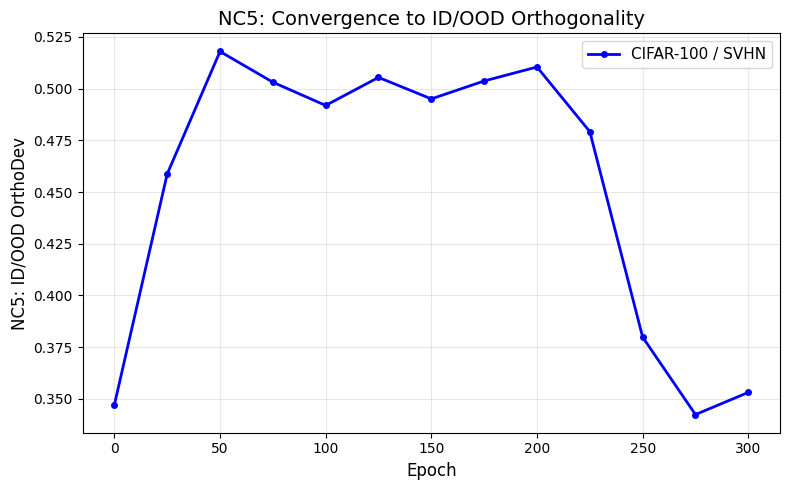

 Saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/ood/nc5_convergence_cifar10.png


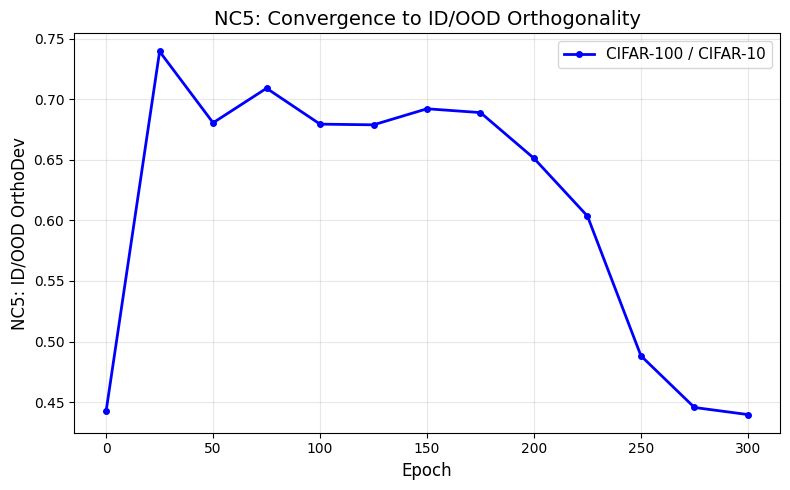

In [13]:
# Individual NC5 plots
fig_svhn = plot_nc5_convergence(
    tracker_svhn, ood_name="SVHN", id_name="CIFAR-100",
    save_dir=figures_dir,
)
plt.show()

fig_c10 = plot_nc5_convergence(
    tracker_cifar10, ood_name="CIFAR-10", id_name="CIFAR-100",
    save_dir=figures_dir,
)
plt.show()

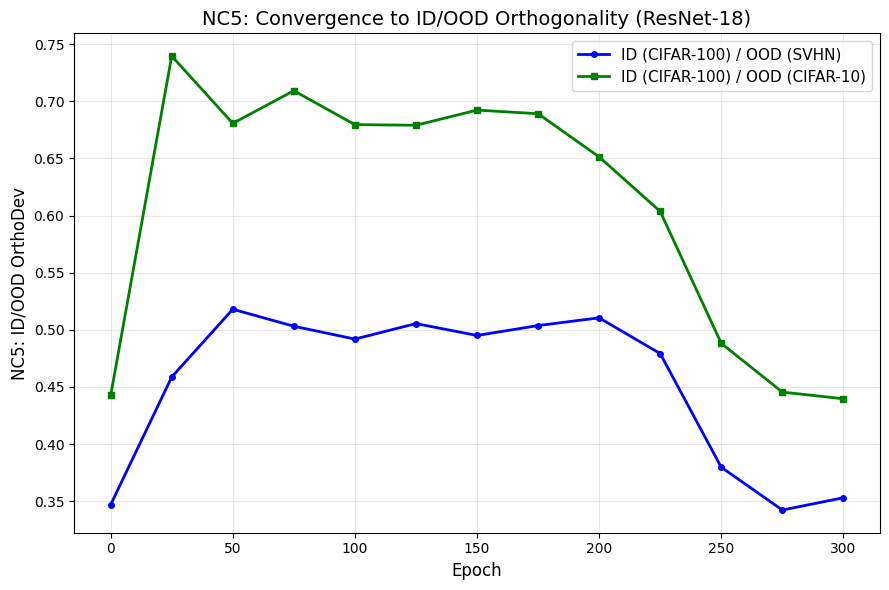

Final NC5 OrthoDev (SVHN):     0.353054
Final NC5 OrthoDev (CIFAR-10): 0.439671


In [14]:
# Combined NC5 plot (both OOD datasets)
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(
    tracker_svhn.epochs, tracker_svhn.nc5_orthodev,
    'b-o', markersize=4, linewidth=2,
    label='ID (CIFAR-100) / OOD (SVHN)',
)
ax.plot(
    tracker_cifar10.epochs, tracker_cifar10.nc5_orthodev,
    'g-s', markersize=4, linewidth=2,
    label='ID (CIFAR-100) / OOD (CIFAR-10)',
)

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('NC5: ID/OOD OrthoDev', fontsize=12)
ax.set_title('NC5: Convergence to ID/OOD Orthogonality (ResNet-18)', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
fig.tight_layout()

plt.savefig(os.path.join(figures_dir, 'nc5_combined.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"Final NC5 OrthoDev (SVHN):     {tracker_svhn.nc5_orthodev[-1]:.6f}")
print(f"Final NC5 OrthoDev (CIFAR-10): {tracker_cifar10.nc5_orthodev[-1]:.6f}")

### 4.2 Full NC Summary with OOD as Extra Class

Following Appendix D.2 of the paper: compare NC1 and NC2 on ID data only vs. ID+OOD (treating OOD as class C+1).

 Saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/ood/nc_ood_summary_svhn.png


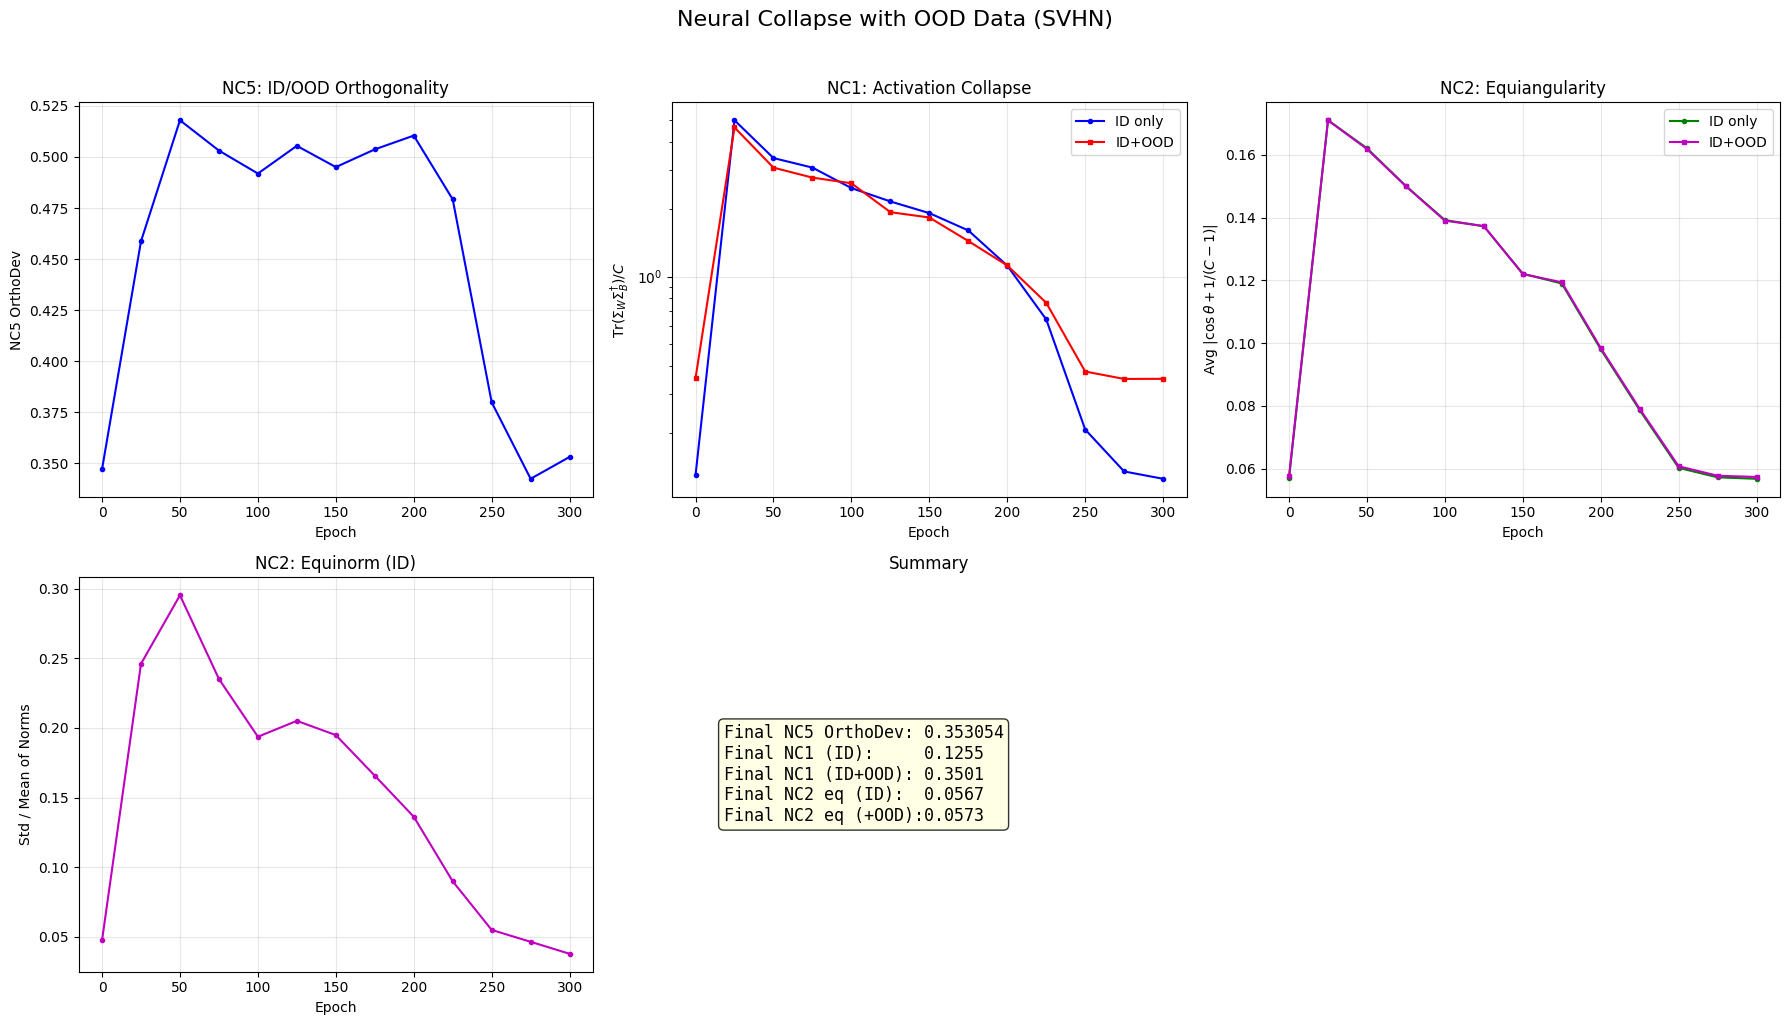

 Saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/ood/nc_ood_summary_cifar10.png


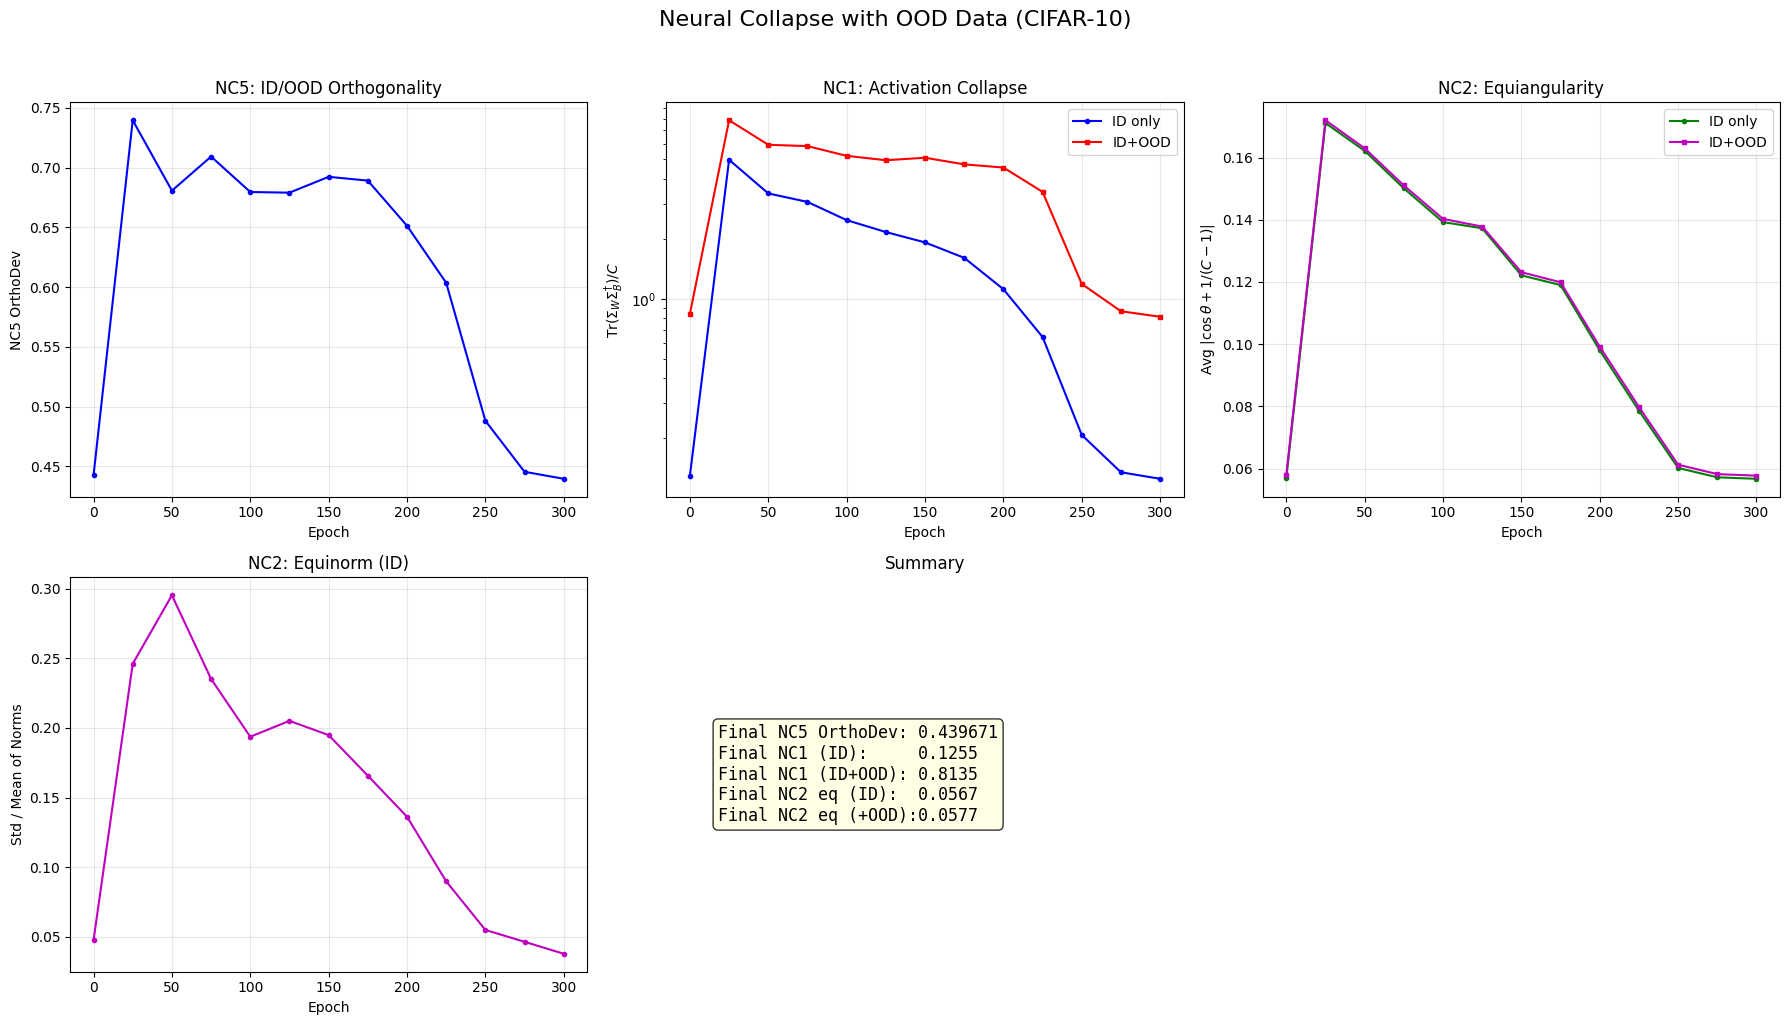

In [15]:
fig_summary_svhn = plot_ood_summary(
    tracker_svhn, ood_name="SVHN", save_dir=figures_dir,
)
plt.show()

fig_summary_c10 = plot_ood_summary(
    tracker_cifar10, ood_name="CIFAR-10", save_dir=figures_dir,
)
plt.show()

### 4.3 Interpretation

We analyse the key findings from the NC5 + NC1/NC2 evolution.

In [16]:
print("\n" + "=" * 60)
print("ANALYSIS: NC5 & OOD BEHAVIOUR")
print("=" * 60)

for name, tracker in [('SVHN', tracker_svhn), ('CIFAR-10', tracker_cifar10)]:
    print(f"\n--- OOD = {name} ---")

    # NC5 decrease
    nc5_start = tracker.nc5_orthodev[0]
    nc5_end = tracker.nc5_orthodev[-1]
    nc5_reduction = (nc5_start - nc5_end) / nc5_start * 100
    print(f"  NC5: {nc5_start:.4f} → {nc5_end:.4f}  ({nc5_reduction:+.1f}%)")

    # NC1 comparison
    nc1_id = tracker.Sw_invSb_id_only[-1]
    nc1_ood = tracker.Sw_invSb_id_ood[-1]
    print(f"  NC1 (ID only):  {nc1_id:.4f}")
    print(f"  NC1 (ID+OOD):   {nc1_ood:.4f}")
    if nc1_ood > nc1_id:
        print(f"  OOD increases NC1 by {(nc1_ood/nc1_id - 1)*100:.1f}% (breaks collapse)")

    # NC2 comparison
    eq_id = tracker.nc2_equiang_id_only[-1]
    eq_ood = tracker.nc2_equiang_id_ood[-1]
    print(f"  NC2 equiang (ID only):  {eq_id:.4f}")
    print(f"  NC2 equiang (ID+OOD):   {eq_ood:.4f}")
    if eq_ood > eq_id:
        print(f"  OOD breaks equiangularity (+{(eq_ood/eq_id - 1)*100:.1f}%)")

print("\n" + "=" * 60)


ANALYSIS: NC5 & OOD BEHAVIOUR

--- OOD = SVHN ---
  NC5: 0.3470 → 0.3531  (-1.7%)
  NC1 (ID only):  0.1255
  NC1 (ID+OOD):   0.3501
  OOD increases NC1 by 179.0% (breaks collapse)
  NC2 equiang (ID only):  0.0567
  NC2 equiang (ID+OOD):   0.0573
  OOD breaks equiangularity (+1.0%)

--- OOD = CIFAR-10 ---
  NC5: 0.4425 → 0.4397  (+0.6%)
  NC1 (ID only):  0.1255
  NC1 (ID+OOD):   0.8135
  OOD increases NC1 by 548.3% (breaks collapse)
  NC2 equiang (ID only):  0.0567
  NC2 equiang (ID+OOD):   0.0577
  OOD breaks equiangularity (+1.8%)



## 5. Load Final Model (for PCA projections)

In [17]:
# Load the final (best) checkpoint for feature extraction
model = ResNet18(num_classes=config['model']['num_classes'])

latest = max(checkpoints, key=get_epoch_num)
epoch_num = get_epoch_num(latest)

ckpt = torch.load(latest, map_location=device, weights_only=False)
if isinstance(ckpt, dict) and 'model_state_dict' in ckpt:
    model.load_state_dict(ckpt['model_state_dict'])
elif isinstance(ckpt, dict) and 'state_dict' in ckpt:
    model.load_state_dict(ckpt['state_dict'])
else:
    model.load_state_dict(ckpt)

model = model.to(device)
model.eval()

print(f"Loaded: {os.path.basename(latest)} (epoch {epoch_num})")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

Loaded: resnet18_cifar100_epoch300.pth (epoch 300)
Parameters: 11,220,132


## 6. PCA Feature Projections

We project the penultimate features (D=512) onto the top principal components
fitted on ID training data. Under Neural Collapse:

- **ID features** form C clusters arranged as a **simplex ETF** in a (C-1)-dimensional subspace
- **OOD features** project **near the origin** (NC5: orthogonal to the ETF subspace)

This is the geometric intuition behind NECO (eq. 6): the ratio $\|Ph\|/\|h\|$ is high for ID (most energy in the ETF subspace) and low for OOD.

### 6.1 PC1 vs PC2 — 2D Projections

Reproducing Figure 2 / D.14 from the NECO paper.

 Saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/ood/pca_2d_svhn.png


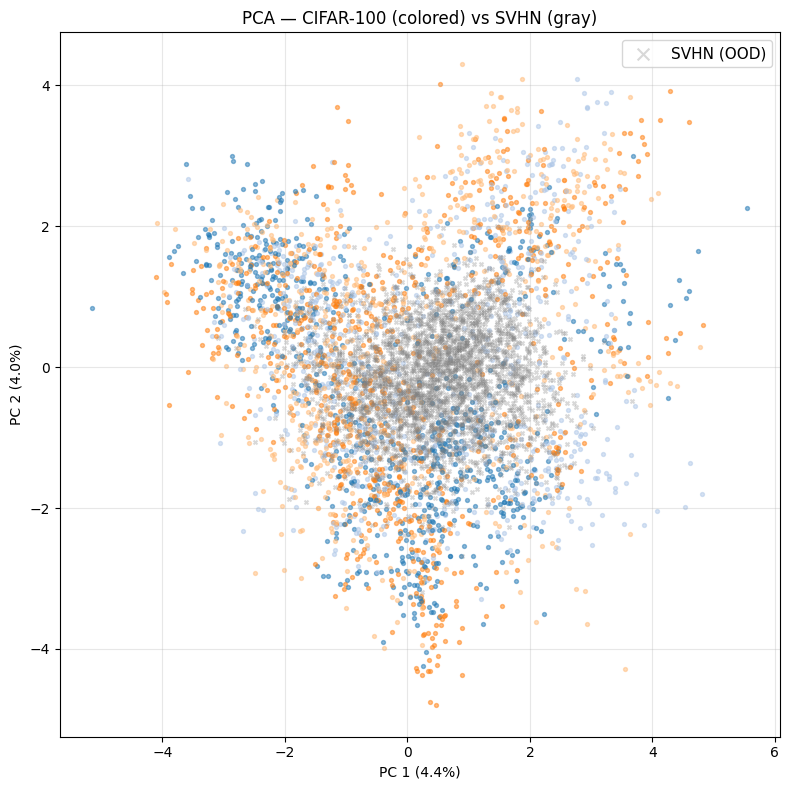

In [18]:
# 2D PCA — CIFAR-100 vs SVHN
fig_pca_svhn = plot_pca_2d(
    model=model,
    id_loader=test_loader,
    ood_loader=svhn_loader,
    device=device,
    num_classes=config['model']['num_classes'],
    id_name="CIFAR-100",
    ood_name="SVHN",
    max_samples=3000,
    save_dir=figures_dir,
)
plt.show()

 Saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/ood/pca_2d_cifar10.png


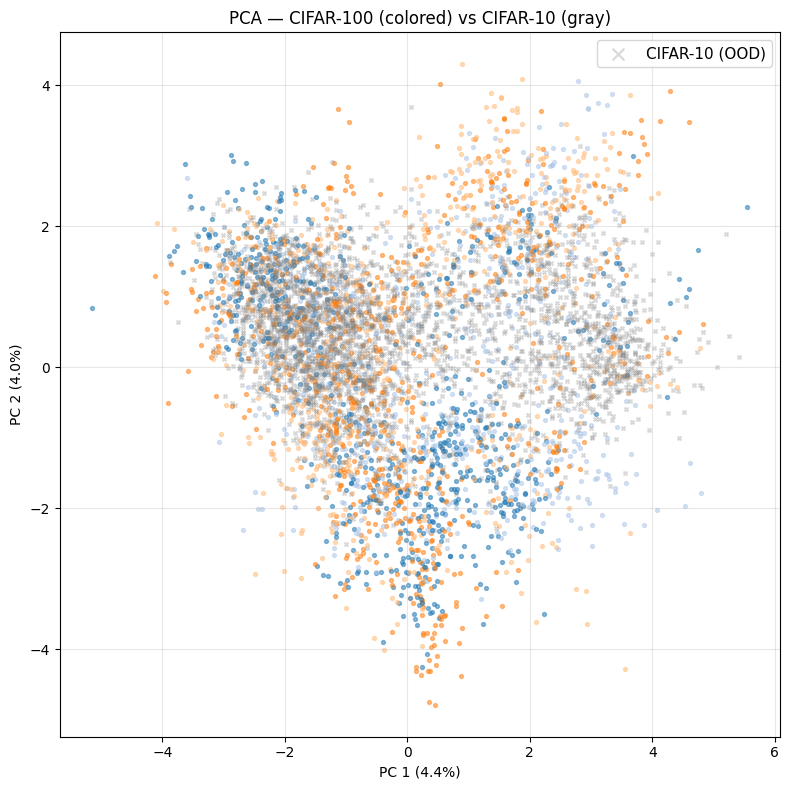

In [19]:
# 2D PCA — CIFAR-100 vs CIFAR-10
fig_pca_c10 = plot_pca_2d(
    model=model,
    id_loader=test_loader,
    ood_loader=cifar10_loader,
    device=device,
    num_classes=config['model']['num_classes'],
    id_name="CIFAR-100",
    ood_name="CIFAR-10",
    max_samples=3000,
    save_dir=figures_dir,
)
plt.show()

### 6.2 PC1 x PC2 x PC3 — Interactive 3D Projections

The 3D projection allows us to **directly observe NC5** (ID/OOD orthogonality):

- **Black diamonds** = ID class means (should form a simplex structure)
- **Red diamond** = OOD global mean $\mu_G^{\text{OOD}}$ (should be near the origin / orthogonal)
- **Red dashed line** = vector from origin to $\mu_G^{\text{OOD}}$

Rotate the 3D plot to verify that the OOD mean direction is roughly perpendicular to the spread of the ID class means.

In [20]:
# 3D interactive PCA — CIFAR-100 vs SVHN
fig_3d_svhn = plot_pca_3d_interactive(
    model=model,
    id_loader=test_loader,
    ood_loader=svhn_loader,
    device=device,
    num_classes=config['model']['num_classes'],
    id_train_loader=train_loader,
    id_name="CIFAR-100",
    ood_name="SVHN",
    max_samples=3000,
    show_class_means=True,
    show_ood_mean=True,
    save_path=os.path.join(figures_dir, 'pca_3d_svhn.html'),
)
fig_3d_svhn.show()

 Saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/ood/pca_3d_svhn.html


In [21]:
# 3D interactive PCA — CIFAR-100 vs CIFAR-10
fig_3d_c10 = plot_pca_3d_interactive(
    model=model,
    id_loader=test_loader,
    ood_loader=cifar10_loader,
    device=device,
    num_classes=config['model']['num_classes'],
    id_train_loader=train_loader,
    id_name="CIFAR-100",
    ood_name="CIFAR-10",
    max_samples=3000,
    show_class_means=True,
    show_ood_mean=True,
    save_path=os.path.join(figures_dir, 'pca_3d_cifar10.html'),
)
fig_3d_c10.show()

 Saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/ood/pca_3d_cifar10.html


## 7. Save Metrics

In [22]:
save_ood_metrics_yaml(
    tracker_svhn,
    os.path.join(metrics_dir, 'nc_ood_svhn_metrics.yaml'),
)
save_ood_metrics_yaml(
    tracker_cifar10,
    os.path.join(metrics_dir, 'nc_ood_cifar10_metrics.yaml'),
)

# Also save as JSON
import json

for name, tracker in [('svhn', tracker_svhn), ('cifar10', tracker_cifar10)]:
    data = tracker.to_dict()
    for key, values in data.items():
        if isinstance(values, list):
            data[key] = [
                v if not (isinstance(v, float) and np.isnan(v)) else None
                for v in values
            ]
    json_path = os.path.join(metrics_dir, f'nc_ood_{name}_metrics.json')
    with open(json_path, 'w') as f:
        json.dump(data, f, indent=2)
    print(f"💾 Saved: {json_path}")

 OOD metrics saved to: /content/drive/MyDrive/Colab Notebooks/OOD/Results/metrics/nc_ood_svhn_metrics.yaml
 OOD metrics saved to: /content/drive/MyDrive/Colab Notebooks/OOD/Results/metrics/nc_ood_cifar10_metrics.yaml
💾 Saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/metrics/nc_ood_svhn_metrics.json
💾 Saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/metrics/nc_ood_cifar10_metrics.json


## 8. Final Summary

In [23]:
print("\n" + "=" * 60)
print("NC OOD ANALYSIS SUMMARY")
print("=" * 60)

print(f"\nModel: ResNet-18 trained on CIFAR-100 (epoch {epoch_num})")
print(f"Epochs analyzed: {len(tracker_svhn.epochs)}")
print(f"Epoch range: {tracker_svhn.epochs[0]} to {tracker_svhn.epochs[-1]}")

print(f"\n--- Final NC5 OrthoDev ---")
print(f"  SVHN:     {tracker_svhn.nc5_orthodev[-1]:.6f}")
print(f"  CIFAR-10: {tracker_cifar10.nc5_orthodev[-1]:.6f}")

print(f"\n--- Files Saved ---")
print(f"  Figures:  {figures_dir}/")
print(f"  3D HTML:  {figures_dir}/pca_3d_svhn.html")
print(f"  3D HTML:  {figures_dir}/pca_3d_cifar10.html")
print(f"  Metrics:  {metrics_dir}/")

print("\n" + "=" * 60)


NC OOD ANALYSIS SUMMARY

Model: ResNet-18 trained on CIFAR-100 (epoch 300)
Epochs analyzed: 13
Epoch range: 0 to 300

--- Final NC5 OrthoDev ---
  SVHN:     0.353054
  CIFAR-10: 0.439671

--- Files Saved ---
  Figures:  /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/ood/
  3D HTML:  /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/ood/pca_3d_svhn.html
  3D HTML:  /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/ood/pca_3d_cifar10.html
  Metrics:  /content/drive/MyDrive/Colab Notebooks/OOD/Results/metrics/

